# Four ways to map precinct-level election results

## Import R libraries

In [1]:
suppressMessages(library('RCurl'))
suppressMessages(library('tidyverse'))
suppressMessages(library('sf'))

## Read in precinct-level results data and shapefiles

Precinct-level results and shapefiles via the Baltimore Sun Data/Interactives team's GitHub repo: [baltimoresun.com/precinct-map](https://github.com/baltimore-sun-data/maryland-2018-governor-precinct-map/tree/master/shapefiles) (the precinct shapefiles for Anne Arundel County were extracted from `md_all` in the [shapefiles]() folder). 

These are results for Anne Arundel's County Executive race.

In [2]:
# results
url <- 'https://raw.githubusercontent.com/baltimore-sun-data/maryland-2018-governor-precinct-map/master/output/results_processed_annearundel_exec.csv'
anne.arundel <- suppressMessages(read_csv(url))

# shapefiles
aa.precincts <- st_read('aa_precincts/aa_precincts.shp', quiet = TRUE)

## Combine results data with precinct shapefiles

In [3]:
merged_aa <- merge(aa.precincts, 
                   anne.arundel, 
                   by = 'ID', 
                   all.x = T)

## Heat map, no density adjustment

This is the map used in the actual story, ["Pittman rode early voting to victory, flipped precincts Schuh won easily in 2014"](https://www.capitalgazette.com/news/elections/ac-cn-executive-precincts-1115-story.html) by Capital reporter Chase Cook. The following code is adapted from the notebook provided in the [GitHub repo accompanying the story](https://github.com/baltimore-sun-data/maryland-2018-governor-precinct-map/blob/master/code/anne_arundel.ipynb).

Create the following color categories to use as color buckets for the map, according to the percentage of the vote received by the winning candidate in the precinct:

- `1`: 50% to 55% of the vote
- `2`: 55% to 60%
- `3`: 60% to 65%
- `4`: 65% to 70%
- `5`: 70% to 75%
- `6`: more than 75%

These are saved in the column `perc_cats`.

**Note**: In order to color the results on a Blue-Red spectrum, we create a column `perc_cats_map` used only for mapping purposes in which the categories for Dem. Steuart Pittman are multiplied by -1 so that they fall on the left-hand side of the number line.

In [4]:
merged_aa <- merged_aa %>% mutate(perc_cats = case_when(perc_winner > 50 & perc_winner <= 55 ~ 1, 
                                                        perc_winner > 55 & perc_winner <= 60 ~ 2,
                                                        perc_winner > 60 & perc_winner <= 65 ~ 3,
                                                        perc_winner > 65 & perc_winner <= 70 ~ 4,
                                                        perc_winner > 70 & perc_winner <= 75 ~ 5,
                                                        perc_winner > 75 ~ 6), 
                                  perc_cats_map = ifelse(winner == 'pittman', perc_cats * -1, 
                                                         perc_cats))

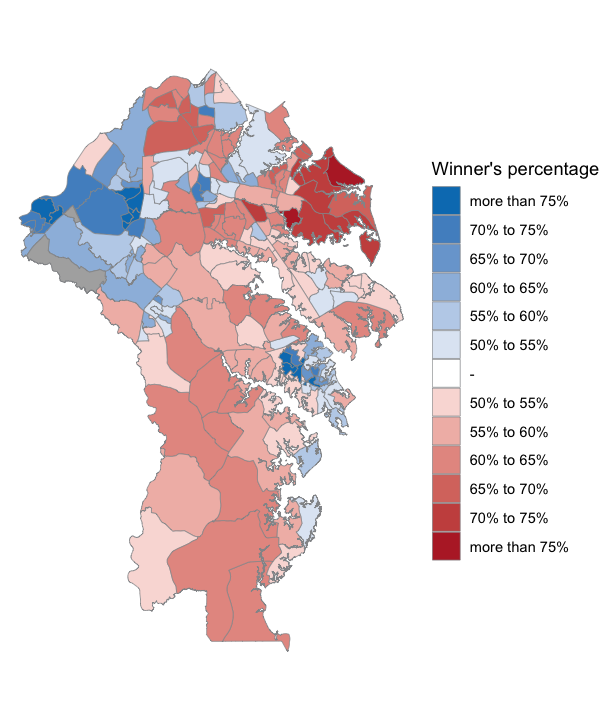

In [8]:
breaks <- seq(-6, 6, 1)

aa.map <- ggplot() + geom_sf(data = merged_aa, aes(fill = perc_cats_map), 
                   color = "#939598", size = 0.2) + 
  scale_fill_gradient2(low = "#007dbe", mid = "white",
                       high = "#b8292f", space = "Lab", midpoint = 0,
                       na.value = "#afafaf", guide = "legend", 
                       aesthetics = "fill", breaks = breaks,
                       labels = c('more than 75%',
                                  '70% to 75%',
                                  '65% to 70%',
                                  '60% to 65%',
                                  '55% to 60%',
                                  '50% to 55%',
                                  '-',
                                  '50% to 55%',
                                  '55% to 60%',
                                  '60% to 65%', 
                                  '65% to 70%',
                                  '70% to 75%',
                                  'more than 75%')) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) + 
  guides(fill = guide_legend(title = "Winner's percentage"))

options(repr.plot.width = 5, repr.plot.height = 6)
print(aa.map)

ggsave("map1.pdf", aa.map, device = 'pdf', width = 6, height = 8)

## *Density adjustments*

Calculate the vote density in each precinct — the number of votes per square mile. This normalizes results from sparsely populated areas.

In [9]:
merged_aa$density <- merged_aa$total_votes / merged_aa$area_mi

Create the `density_cut` column, which divides `density` into three equally-sized groups

In [10]:
density_cut = as.numeric(cut_number(merged_aa$density, 3))

## Heat map, with density adjustment

Use `density_cut` to determine the opacity of the shading via `alpha = as.factor(density_cut)` and `scale_alpha_discrete(range = c(0.4, 1), guide = 'none')`.

Warning message:
“Using alpha for a discrete variable is not advised.”

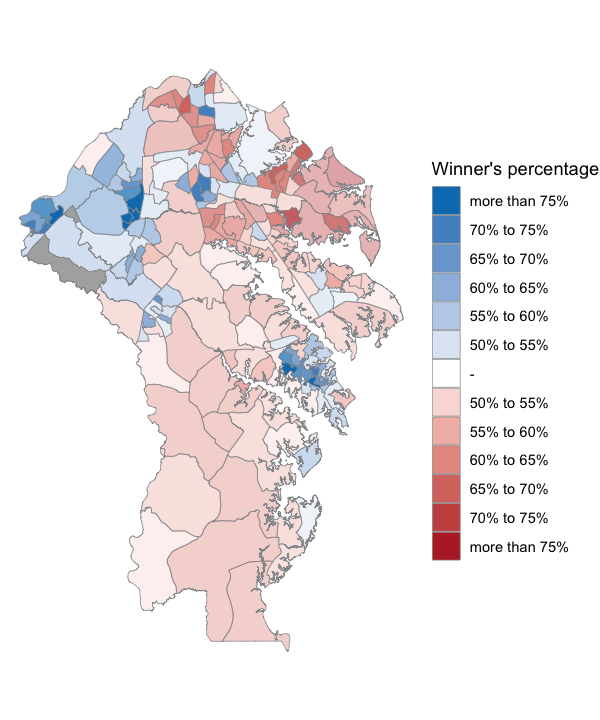

In [12]:
breaks <- seq(-6, 6, 1)

aa.map.density <- ggplot() + geom_sf(data = merged_aa, aes(fill = perc_cats_map, alpha = as.factor(density_cut)), 
                   color = "#939598", size = 0.2) + 
  scale_fill_gradient2(low = "#007dbe", mid = "white",
                       high = "#b8292f", space = "Lab", midpoint = 0,
                       na.value = "#afafaf", guide = "legend", 
                       aesthetics = "fill", breaks = breaks,
                       labels = c('more than 75%',
                                  '70% to 75%',
                                  '65% to 70%',
                                  '60% to 65%',
                                  '55% to 60%',
                                  '50% to 55%',
                                  '-',
                                  '50% to 55%',
                                  '55% to 60%',
                                  '60% to 65%', 
                                  '65% to 70%',
                                  '70% to 75%',
                                  'more than 75%')) +
  scale_alpha_discrete(range = c(0.4, 1), guide = 'none') +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) + 
  guides(fill = guide_legend(title = "Winner's percentage"))

options(repr.plot.width = 5, repr.plot.height = 6)
print(aa.map.density)

ggsave("map2.pdf", aa.map.density, device = 'pdf', width = 6, height = 8)

## *Dot maps*

Calculate the centroid of each precinct using `st_centroid()`

In [14]:
centroid_poly <- merged_aa

sf_cent <- st_centroid(centroid_poly, byid = TRUE)
sf_cent.df <- as.data.frame(sf_cent)

sf_cent.df <- cbind(sf_cent.df, st_coordinates(sf_cent)) %>% rename(long = X, lat = Y)

Warning message in st_centroid.sf(centroid_poly, byid = TRUE):
“st_centroid assumes attributes are constant over geometries of x”Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”

## Dot map, no density adjustment

Create the following color categories to use as color buckets for the map, according to the margin of victory (in percentage points) of the winning candidate in the precinct:

- `1`: less than 5 points
- `2`: 5 to 10 points
- `3`: 10 to 20 points
- `4`: 20 to 30 points
- `5`: 30 to 40 points
- `6`: 40 to 50 points
- `7`: more than 50 points

These are saved in the column `victory_cats`.

In [15]:
sf_cent.df <- sf_cent.df %>% mutate(victory_cats = case_when(winner_margin <= 5 ~ 1,
                                                           winner_margin <= 10 ~ 2,
                                                           winner_margin > 10 & winner_margin <= 20 ~ 3,
                                                           winner_margin > 20 & winner_margin <= 30 ~ 4,
                                                           winner_margin > 30 & winner_margin <= 40 ~ 5,
                                                           winner_margin > 40 & winner_margin <= 50 ~ 6,
                                                           winner_margin >= 50 ~ 7))

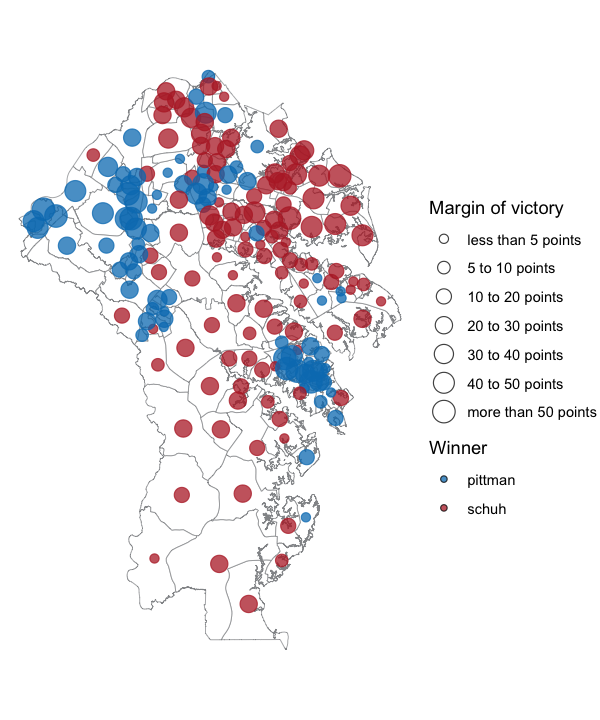

In [34]:
aa.map.dot <- ggplot() + 
  geom_sf(data = centroid_poly, fill = 'white', color = "#939598", size = 0.2) +
  geom_point(data = sf_cent.df %>% filter(!is.na(winner)), aes(x = long, y = lat,
                                    color = winner, fill = winner, size = victory_cats), pch = 21, alpha = .75) +
  scale_color_manual(values = c('#007dbe', '#b8292f'), guide = 'none') +
  scale_fill_manual(values = c('#007dbe', '#b8292f')) +
  scale_size_area(labels = c('less than 5 points',
                             '5 to 10 points',
                             '10 to 20 points',
                             '20 to 30 points',
                             '30 to 40 points',
                             '40 to 50 points',
                             'more than 50 points')) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) +
  guides(fill = guide_legend(title = "Winner"), 
         size = guide_legend(title = "Margin of victory"))

options(repr.plot.width = 5, repr.plot.height = 6)

print(aa.map.dot)

ggsave("map3.pdf", aa.map.dot, device = 'pdf', width = 6, height = 8)

## Dot map, density adjustment

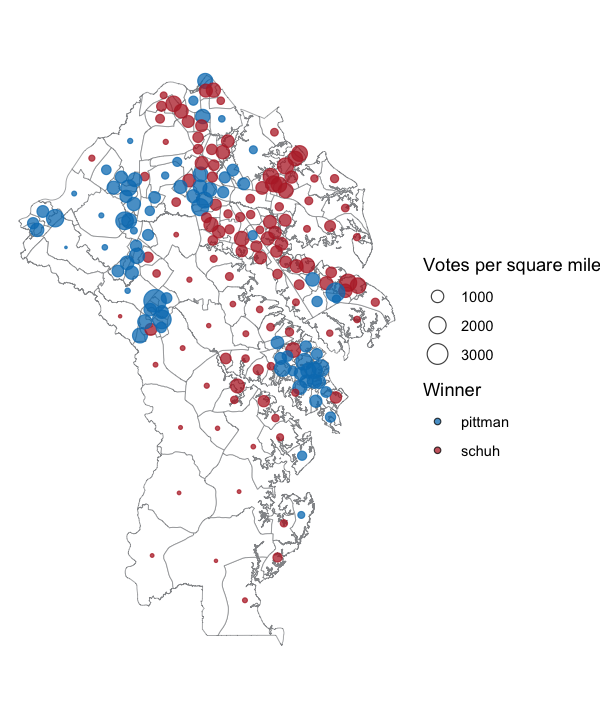

In [36]:
aa.map.dot.density <- ggplot() + 
  geom_sf(data = centroid_poly, fill = 'white', color = "#939598", size = 0.2) +
  geom_point(data = sf_cent.df %>% filter(!is.na(winner)), aes(x = long, y = lat,
                                    color = winner, fill = winner, size = density), pch = 21, alpha = .75) +
  scale_color_manual(values = c('#007dbe', '#b8292f'), guide = 'none') +
  scale_fill_manual(values = c('#007dbe', '#b8292f')) +
  scale_size_area() +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) +
  guides(fill = guide_legend(title = "Winner"), 
         size = guide_legend(title = "Votes per square mile"))

options(repr.plot.width = 5, repr.plot.height = 6)

print(aa.map.dot.density)

ggsave("map4.pdf", aa.map.dot.density, device = 'pdf', width = 6, height = 8)